In [1]:
! pip install torchdiffeq

In [1]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import models.stribor_lib as st
import torch
import numpy as np
from tqdm import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set flow models for jets

In [3]:
device = 'cpu'  # ['cuda', 'cpu', or 'mps']

## Define set flow model

Load model from https://arxiv.org/abs/2010.03242

In [163]:
def get_exact_model(dim, hidden_dims, latent_dim, context_dim=0, n_transforms=4, set_data=False, device='mps', atol=1e-4):
    
    has_latent = True if context_dim > 0 else False
    
    transforms = []
    
    for _ in range(n_transforms):
        transforms.append(st.ContinuousNormalizingFlow(dim, net=st.net.DiffeqExactTraceDeepSet(dim, hidden_dims, dim, d_h=latent_dim, latent_dim=context_dim).to(device),
                                            divergence='exact', solver='dopri5', atol=atol, has_latent=has_latent, set_data=set_data).to(device))
        
    model = st.Flow(st.Normal(torch.zeros(dim).to(device), torch.ones(dim).to(device)), transforms).to(device)
    
    return model

## Basic tests with conditioning context

In [164]:
dim = 5
context_dim = 15

In [165]:
model = get_exact_model(dim=dim, hidden_dims=[64, 64], latent_dim=4, context_dim=context_dim, n_transforms=2, 
                        set_data=True, device=device)

In [166]:
context = torch.rand(8, context_dim)
context = context.unsqueeze(-2).repeat_interleave(2, dim=-2).to(device)  # Replicate context over particle dimension

x = torch.rand(8, 2, dim).to(device)

y, ldj = model(x, latent=context)

In [167]:
model.log_prob(x, latent=context).sum()

tensor(-82.9899, grad_fn=<SumBackward0>)

In [168]:
# Test permutation invariance
model.log_prob(torch.flip(x, [-2]), latent=context).sum()

tensor(-82.9899, grad_fn=<SumBackward0>)

## Variable-sized data and masking

In [169]:
dim = 5  # Dim of density per object to be modeled
context_dim = 2  # Context
obj_dim_max = 10  # Max number of objects

In [170]:
lens = torch.randint(0, obj_dim_max, [8]).to(torch.float32)
mask = (torch.arange(obj_dim_max).expand(len(lens), obj_dim_max) < torch.Tensor(lens)[:,None]).float()
mask = mask.unsqueeze(-1).to(device)

In [171]:
mask.shape

torch.Size([8, 10, 1])

In [172]:
model = get_exact_model(dim=dim, hidden_dims=[64, 64], latent_dim=4, context_dim=context_dim, n_transforms=2, 
                        set_data=True, device=device)

In [173]:
context = torch.rand(8, context_dim)
context = context.unsqueeze(-2).repeat_interleave(obj_dim_max, dim=-2).to(device)

x = torch.rand(8, obj_dim_max, dim).to(device)

y, ldj = model(x, latent=context, mask=mask)

In [174]:
# Flip mask as well as object order
model.log_prob(x, latent=context, mask=mask).sum(), model.log_prob(torch.flip(x, [-2]), latent=context, mask=torch.flip(mask, [-2])).sum()

(tensor(-385.8177, grad_fn=<SumBackward0>),
 tensor(-385.8177, grad_fn=<SumBackward0>))

## Jets

In [175]:
# Data from https://zenodo.org/record/4834876#.Y0UkO-xBzzc
q_jets = np.genfromtxt("../data/q_jets.csv")

In [226]:
from einops import rearrange

q_jets_rearranged = rearrange(q_jets, "N (particles properties) -> N particles properties", particles=30)

In [228]:
model = get_exact_model(dim=3, hidden_dims=[128, 128], latent_dim=8, context_dim=0, n_transforms=4, 
                        set_data=True, device=device, atol=1e-4)

In [229]:
x = torch.Tensor(q_jets_rearranged[:, :, :3]).to(device)
mask = torch.Tensor(q_jets_rearranged[:, :, 3:]).to(device)

mask[mask > 0] = 1
mask[mask < 0] = 0

In [230]:
x.shape

torch.Size([170679, 30, 3])

In [231]:
model.log_prob(torch.Tensor(x[:64]), mask=mask[:64]).sum()  # Test

tensor(-5035.9268, grad_fn=<SumBackward0>)

In [263]:
def train_flow(dataset, mask, params, batch_size=128, n_steps=512, lr=1e-4):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.AdamW(params, lr=lr)
    
    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = torch.Tensor(np.random.choice(dataset.shape[0], batch_size)).to(torch.int64)
        
        dataset_batch = dataset[idxs,:]
        mask_batch = mask[idxs,:]
        
        loss = -model.log_prob(dataset_batch).mean()
        
        loss.backward()
        optimizer.step()

        if i_step % 10 == 0: print('Step: {}; Loss: {}'.format(i_step, loss.item()))

In [264]:
train_flow(x, mask, model.parameters(), n_steps=100)

  1%|▋                                                                  | 1/100 [00:05<09:10,  5.56s/it]

Step: 0; Loss: -6.512282371520996


 11%|███████▎                                                          | 11/100 [00:58<07:26,  5.02s/it]

Step: 10; Loss: -6.38782262802124


 21%|█████████████▊                                                    | 21/100 [01:51<07:04,  5.38s/it]

Step: 20; Loss: -6.262308120727539


 31%|████████████████████▍                                             | 31/100 [02:42<05:55,  5.15s/it]

Step: 30; Loss: -6.296501159667969


 41%|███████████████████████████                                       | 41/100 [03:33<05:07,  5.21s/it]

Step: 40; Loss: -6.17902135848999


 51%|█████████████████████████████████▋                                | 51/100 [04:25<04:17,  5.25s/it]

Step: 50; Loss: -6.437013149261475


 61%|████████████████████████████████████████▎                         | 61/100 [05:15<03:14,  5.00s/it]

Step: 60; Loss: -6.129839897155762


 71%|██████████████████████████████████████████████▊                   | 71/100 [06:06<02:33,  5.30s/it]

Step: 70; Loss: -6.662096977233887


 81%|█████████████████████████████████████████████████████▍            | 81/100 [06:58<01:37,  5.14s/it]

Step: 80; Loss: -6.365732192993164


 91%|████████████████████████████████████████████████████████████      | 91/100 [07:50<00:48,  5.41s/it]

Step: 90; Loss: -6.308622360229492


100%|█████████████████████████████████████████████████████████████████| 100/100 [08:39<00:00,  5.19s/it]


In [265]:
# Get cardinality distribution from training data
unique, counts = np.unique((mask[:, :, -1].sum(-1)), return_counts=True)  

 12%|████████▌                                                           | 2/16 [00:00<00:01, 11.78it/s]

0.86785626
0.80592096
1.0010962


 38%|█████████████████████████▌                                          | 6/16 [00:00<00:00, 10.90it/s]

1.3366511
1.0934601
1.2027223


 50%|██████████████████████████████████                                  | 8/16 [00:00<00:00, 11.88it/s]

0.8584052
1.0839316
0.76062787


 75%|██████████████████████████████████████████████████▎                | 12/16 [00:01<00:00, 12.45it/s]

0.92618126
0.79248714
1.310266


 88%|██████████████████████████████████████████████████████████▋        | 14/16 [00:01<00:00, 12.64it/s]

0.76164985
1.3058783
0.8377998


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.21it/s]


1.0061085


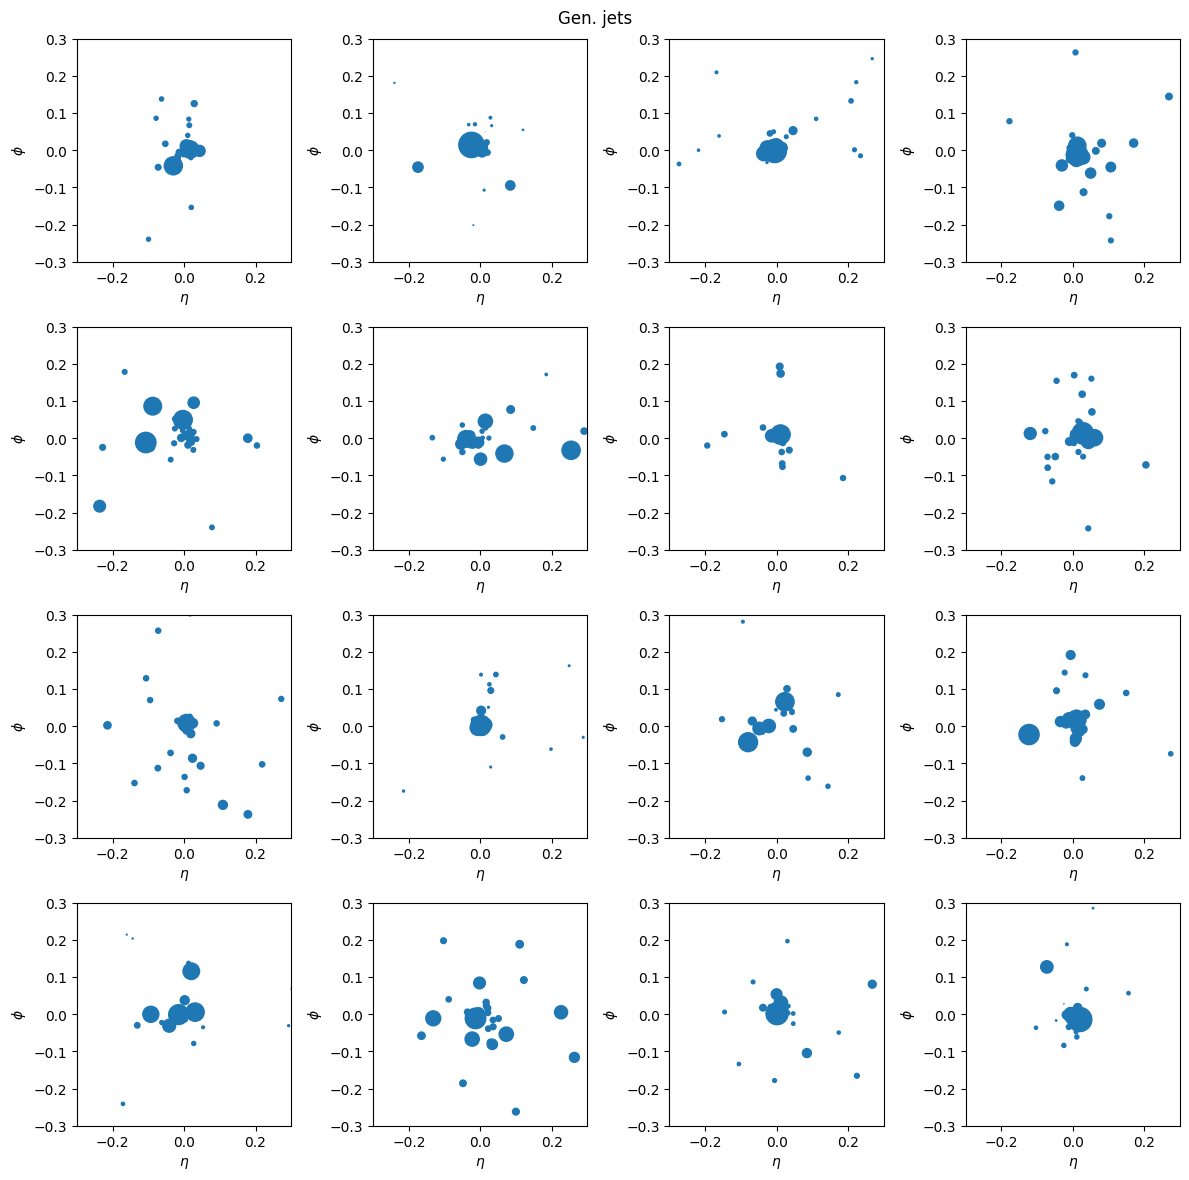

In [266]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    n_particles = int(np.random.choice(unique, p=counts / np.sum(counts)))
    x_sample = np.array(model.sample(num_samples=(n_particles)).detach())
    
    print(x_sample[:, -1].sum())

    ax.scatter(*x_sample[:, :2].T, s=1000 * np.abs(x_sample[:, 2]))  # Hacky np.abs!!
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets")
plt.tight_layout()

100%|███████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 85.59it/s]


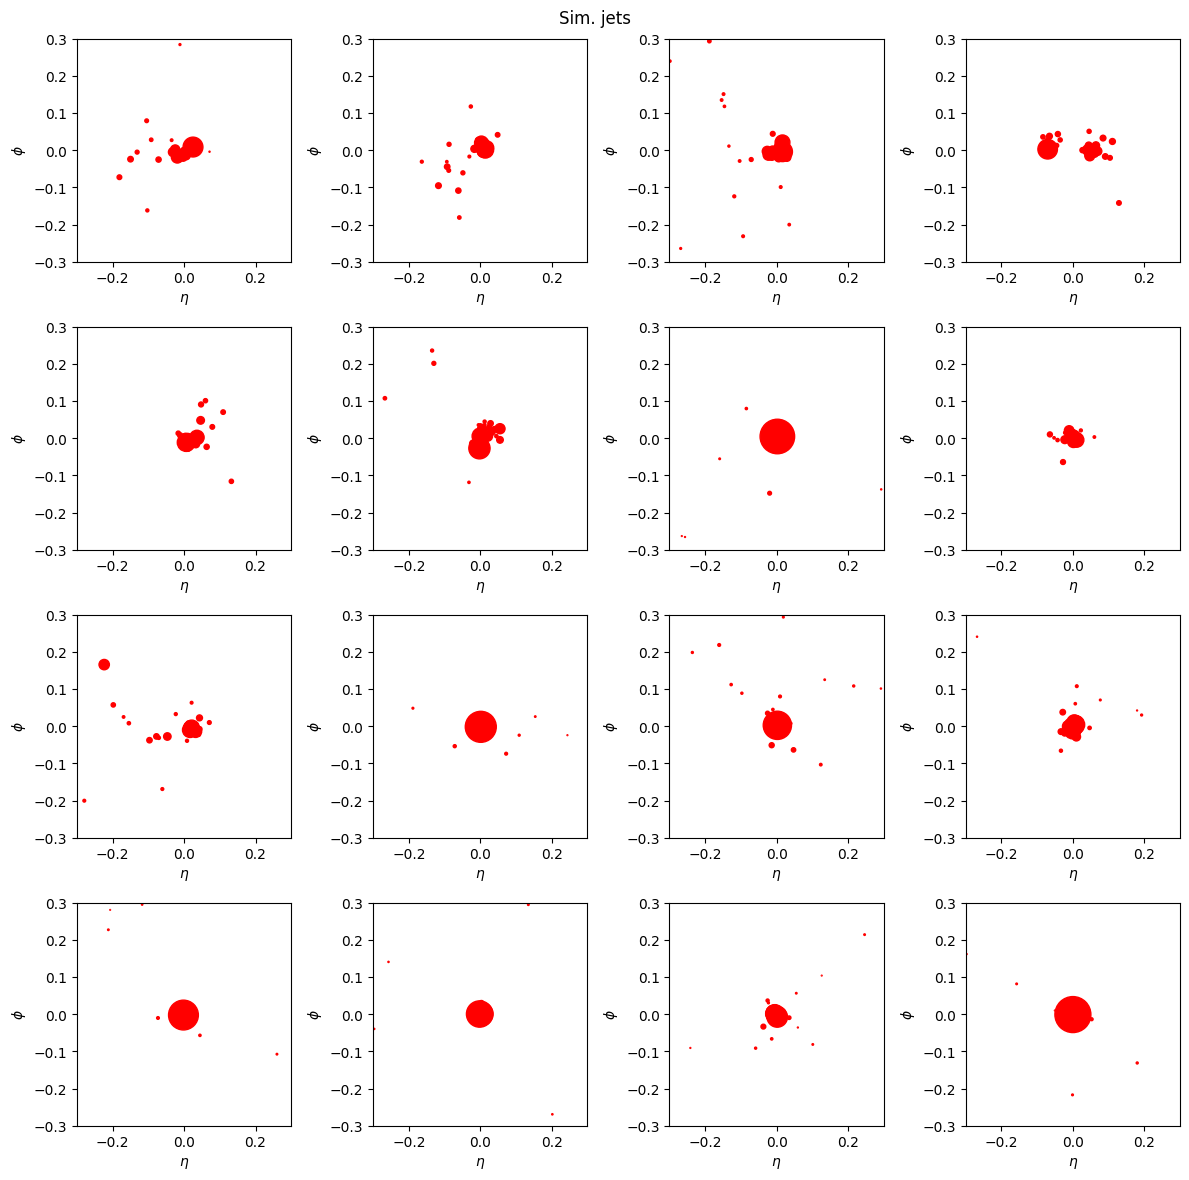

In [268]:
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
    
    idx = np.random.randint(len(x))
    x_plot = x[idx, :, :2]
    s_plot = np.abs(x[idx, :, 2])
    s_plot[mask[idx, :, 0] < 0.] = 0.

    ax.scatter(*x_plot.T, s=1000 * s_plot, color='red')    
        
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets")
plt.tight_layout()